In [6]:
from qiskit import QuantumCircuit, execute, Aer
from qiskit.visualization import plot_histogram
from qiskit.circuit import Parameter
from numpy import pi
import numpy as np

In [7]:
"""逆量子フーリエ変換
"""
def qft_rotate_sinle_inv(qc, i, n):
    if n == 0:
        return qc
    for q in range(0, i):
        qc.cp(-pi/2**(i-q), q, i)
    qc.h(i)

def qft_dagger(qc, n):
    for i in range(n//2):
        qc.swap(i, n-(i+1))    
    for i in range(n):
        qft_rotate_sinle_inv(qc, i, n)

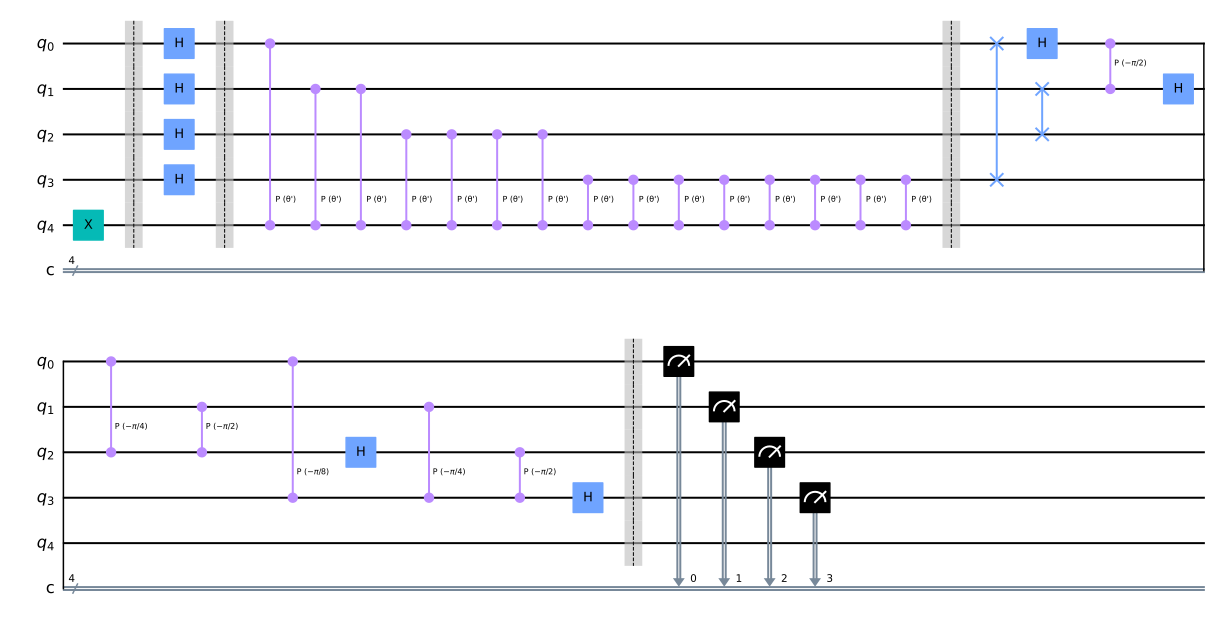

In [111]:
"""量子回路を作成
"""
n_encode = 4  # 求めたい固有値の位相角をエンコードする量子ビット数
n_eigstate = 1  # 固有状態の量子ビット数
n = n_encode + n_eigstate
theta = Parameter("θ'")

# 回路作成
qc = QuantumCircuit(n, n_encode)
qc.x(n_encode)  # 固有状態を用意
qc.barrier()

# 重ね合わせ状態を作る
for q in range(n_encode):
    qc.h(q)
qc.barrier()

# repetitions
repetitions = 1
for count in range(n_encode):
    for i in range(repetitions):
        qc.cp(theta, count, n_encode)
    repetitions *= 2
qc.barrier()

# qft_dagger
qft_dagger(qc, n_encode)
qc.barrier()

# 測定
for n in range(n_encode):
    qc.measure(n, n)

qc.draw()

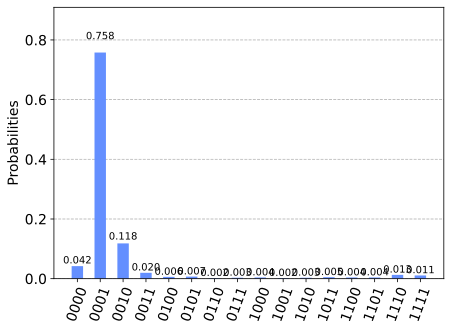

In [181]:
"""実行
"""
# 位相を決める
phase = np.random.rand()

# qc_parametrized = [qc.bind_parameters({theta: phase}) for i in range(2**n_encode-1)][-1]
qc_parametrized = qc.bind_parameters({theta: phase})
backend = Aer.get_backend("aer_simulator")
shots = 1024
results = execute(qc_parametrized, backend=backend, shots=shots).result()
counts = results.get_counts()
plot_histogram(counts)

In [182]:
"""位相推定値の算出
コード内で設定したパラメータθ'より換算したθ（＝真値）と、位相推定により推定されたパラメータθ（＝推定値）を比較してみる。

位相推定により真値に近いパラメータθを推定できていることがわかる。

また、量子ビット数を増やすことで、より近似制度の高い結果を得ることができる。
"""
ans_idx = np.argmax(list(results.get_counts().values()))
phase_estimated = ans_idx / (2**n_encode)
print("True phase: {:.4f}".format(phase/(2*np.pi)))
print("Estimated phase: {:.4f}".format(phase_estimated))

True phase: 0.0800
Estimated phase: 0.0625
